In [461]:
import numpy as np
from rdkit import Chem
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

In [462]:
df = pd.read_pickle("dataset_final.pickle")
df_soap_mean = df.copy().reindex(columns = ["canonical smiles","SOAP mean","h298"])
df_soap_mean= df_soap_mean.rename(columns={"h298":"h298(Hartree)"})
df_soap_sum = df.copy().reindex(columns = ["SOAP sum","h298"])
df_soap_sum = df_soap_sum.rename(columns={"h298":"h298(Hartree)"})

In [463]:
def partSOAP(dataset,coluna_soap):
    dataset_copy = dataset.copy()
    novas_colunas = []
    coluna = dataset_copy[coluna_soap]
    for i in range(len(coluna[0])):
        novas_colunas.append(f'{i}')
    dataset_copy = dataset_copy.copy().join(pd.DataFrame(coluna.tolist(),
                                                                      columns=novas_colunas))
    dataset_copy = dataset_copy.drop(columns=coluna_soap)
    
    return dataset_copy

In [464]:
df_soap_sum_parti = partSOAP(df_soap_sum,'SOAP sum')

In [465]:
seed = 0
train_soap_sum = df_soap_sum_parti.sample(frac=0.8,random_state=seed)
teste_soap_sum = df_soap_sum_parti.drop(train_soap_sum.index)

In [466]:
train_labels = train_soap_sum.pop("h298(Hartree)")
test_labels = teste_soap_sum.pop("h298(Hartree)")

In [467]:
shape=(len(train_soap_sum.keys()))
shape

6

In [468]:
def build_model():
    model = keras.Sequential([
        keras.Input(shape=(len(train_soap_sum.keys()))),
        layers.Dense(10, activation='sigmoid', name='layer1'), # (15+1)*10 = 169 pesos
        layers.Dense(10, activation='linear', name='layer2'), # (10+1)*10 = 110 pesos
        layers.Dense(1, activation='linear', name="layer3") # (10+1)*1 = 11 pesos
        ])

    # Tipo de Otimizador Kera: RMSprop
    # Otimizadores são o conceito geral usado em redes neurais porque envolvem inicializar aleatoriamente e 
    # manipular o valor dos pesos para cada época para aumentar o potencial de precisão da rede modelo.
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.01, epsilon=1e-07) # taxa de aprendizagem=0.001

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse', 'mae'])
    return model

model = build_model()
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 10)                70        
                                                                 
 layer2 (Dense)              (None, 10)                110       
                                                                 
 layer3 (Dense)              (None, 1)                 11        
                                                                 
Total params: 191 (764.00 Byte)
Trainable params: 191 (764.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [476]:
checkpoint_path = "check"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1, 
    save_weights_only=True, 
    monitor='loss',
    mode='max',
    save_best_only=True)


In [470]:
EPOCHS = 100
history = model.fit(train_soap_sum, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/100
1008/1014 [============================>.] - ETA: 0s - loss: 138018.5156 - mse: 138018.5156 - mae: 368.2877
Epoch 1: loss improved from -inf to 137802.39062, saving model to check
1014/1014 [==============================] - 3s 2ms/step - loss: 137802.3906 - mse: 137802.3906 - mae: 367.9739 - val_loss: 99719.7891 - val_mse: 99719.7891 - val_mae: 313.0978
Epoch 2/100
1011/1014 [============================>.] - ETA: 0s - loss: 51964.0938 - mse: 51964.0938 - mae: 215.7497
Epoch 2: loss did not improve from 137802.39062
1014/1014 [==============================] - 2s 2ms/step - loss: 51863.2031 - mse: 51863.2031 - mae: 215.4595 - val_loss: 11482.2031 - val_mse: 11482.2031 - val_mae: 99.8013
Epoch 3/100
1003/1014 [============================>.] - ETA: 0s - loss: 2857.0967 - mse: 2857.0967 - mae: 42.2535
Epoch 3: loss did not improve from 137802.39062
1014/1014 [==============================] - 2s 2ms/step - loss: 2845.6289 - mse: 2845.6289 - mae: 42.1601 - val_loss: 1692.9850

In [471]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
95,186.829117,186.829117,8.701447,163.762680,163.762680,8.154267,95
96,185.497437,185.497437,8.638655,248.422791,248.422791,11.648362,96
97,186.468460,186.468460,8.651795,164.968216,164.968216,8.414227,97
98,187.258392,187.258392,8.610332,199.324310,199.324310,8.166778,98
99,185.470932,185.470932,8.594001,181.580872,181.580872,7.934227,99


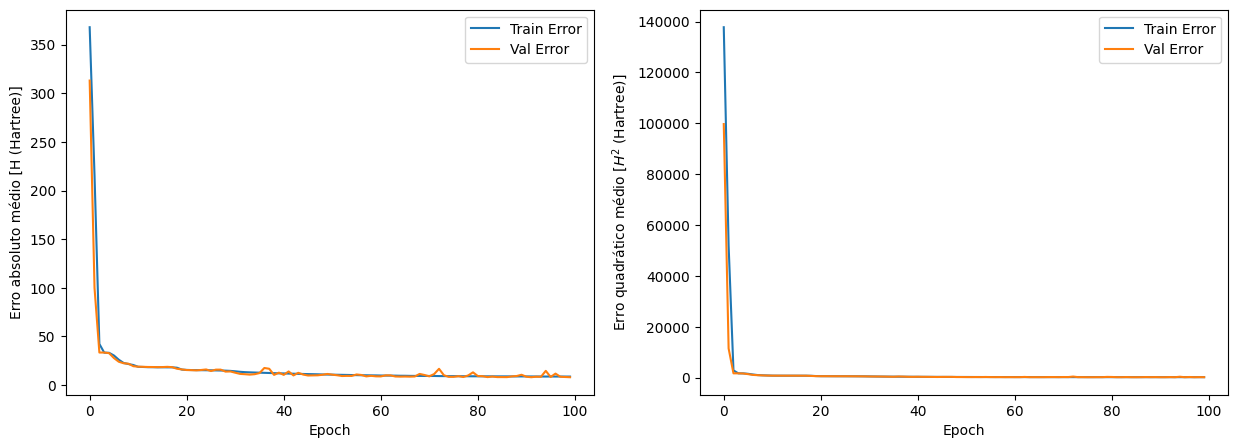

In [472]:
import matplotlib.pyplot as plt
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    fig, axs = plt.subplots(1,2, figsize=(15, 5))
    #axs[0].plt.figure()
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Erro absoluto médio [H (Hartree)]') # troca nome
    axs[0].plot(hist['epoch'], hist['mae'], label='Train Error')
    axs[0].plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    #plt.ylim([0,5]) 
    axs[0].legend()

    #axs[1].figure()
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Erro quadrático médio [$H^2$ (Hartree)]') # troca nome
    axs[1].plot(hist['epoch'], hist['mse'], label='Train Error')
    axs[1].plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    #plt.ylim([0,20])
    axs[1].legend()


plot_history(history)

317/317 [==============================] - 1s 3ms/step


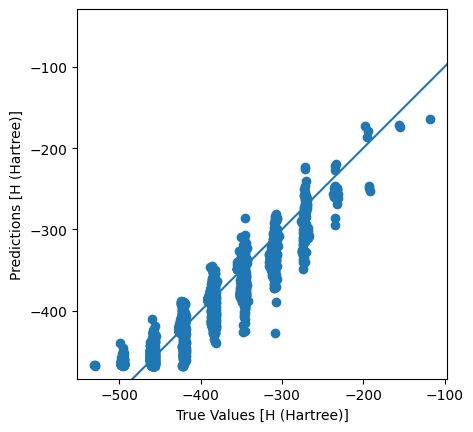

In [473]:
test_predictions = model.predict(teste_soap_sum).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [H (Hartree)]')
plt.ylabel('Predictions [H (Hartree)]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-25000, 25000], [-25000, 25000])

In [474]:
import sklearn
from sklearn.metrics import r2_score

# Calcular R quadrado
print('R score is :', r2_score(test_labels, test_predictions))

R score is : 0.8887495826465847


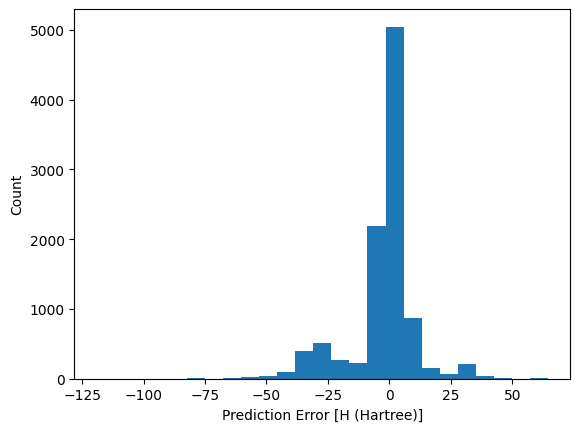

In [475]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [H (Hartree)]")
_ = plt.ylabel("Count")